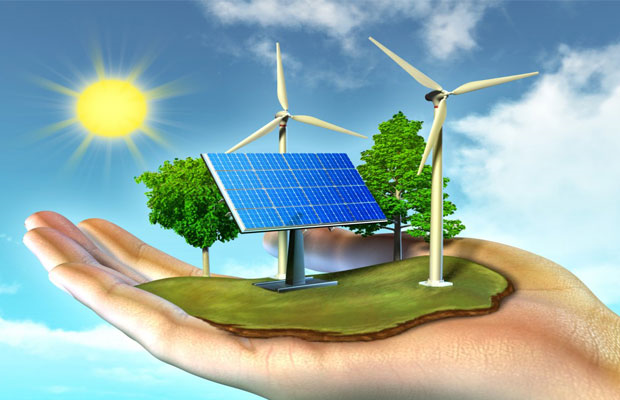

#                                               Forecast Green Energy

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
import datetime
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# loading Data

train.csv - the training set, which includes the  datetime and energy.
test.csv  - the test set; date time and row_id
sample_submission.csv - a sample submission file in the correct format

In [2]:
train=pd.read_csv("/kaggle/input/traing-dataset-for-forcast-green-energy/train.csv")


In [3]:
train

,row_id,datetime,energy
0,1,01-03-2008 00:00,1259.985563
1,2,01-03-2008 01:00,1095.541500
2,3,01-03-2008 02:00,1056.247500
3,4,01-03-2008 03:00,1034.742000
4,5,01-03-2008 04:00,1026.334500
...,...,...,...
94987,94988,31-12-2018 19:00,2528.446800
94988,94989,31-12-2018 20:00,2461.883600
94989,94990,31-12-2018 21:00,2365.994400
94990,94991,31-12-2018 22:00,2342.942800


In [4]:
train.head()

,row_id,datetime,energy
0,1,01-03-2008 00:00,1259.985563
1,2,01-03-2008 01:00,1095.541500
2,3,01-03-2008 02:00,1056.247500
3,4,01-03-2008 03:00,1034.742000
4,5,01-03-2008 04:00,1026.334500


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [6]:
train.shape

(94992, 3)

# Loading  simple impute from sklearn

In [7]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
train.energy= my_imputer.fit_transform(train['energy'].values.reshape(-1,1))
train

,row_id,datetime,energy
0,1,01-03-2008 00:00,1259.985563
1,2,01-03-2008 01:00,1095.541500
2,3,01-03-2008 02:00,1056.247500
3,4,01-03-2008 03:00,1034.742000
4,5,01-03-2008 04:00,1026.334500
...,...,...,...
94987,94988,31-12-2018 19:00,2528.446800
94988,94989,31-12-2018 20:00,2461.883600
94989,94990,31-12-2018 21:00,2365.994400
94990,94991,31-12-2018 22:00,2342.942800


In [8]:
train.isnull().sum()

row_id      0
datetime    0
energy      0
dtype: int64

# Exploratory Analysis

In [9]:
train.index

RangeIndex(start=0, stop=94992, step=1)

In [10]:
df=train.set_index(pd.DatetimeIndex(train['datetime'])).drop("datetime",axis=1)

In [11]:
daily_data = df.resample(rule='D').sum()

# Set frequency explicitly to D
daily_data = daily_data.asfreq('D')

daily_data.head()

,row_id,energy
datetime,,
2008-01-03,300,30336.129563
2008-01-04,18156,30420.105000
2008-01-05,35436,34332.867000
2008-01-06,53292,27509.315400
2008-01-07,70572,37854.411014


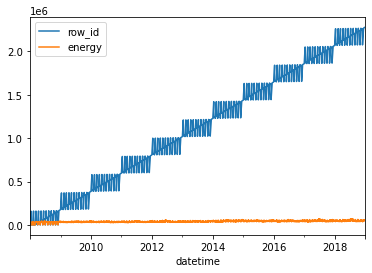

In [12]:
daily_data.plot()
plt.show()

In [13]:
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Weekday_Name'] = daily_data.index.day_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2008]
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='energy')

# Reorder columns
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head()

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2009,1.744955e+06,1.840775e+06,1.889542e+06,1.911826e+06,1.842005e+06,1.854955e+06,1.765100e+06
2010,1.727170e+06,1.818704e+06,1.834243e+06,1.869569e+06,1.873869e+06,1.812176e+06,1.723814e+06
2011,1.751580e+06,1.884760e+06,1.935010e+06,1.896525e+06,1.919103e+06,1.912600e+06,1.812340e+06
2012,1.935040e+06,1.964903e+06,2.027407e+06,2.035109e+06,1.972666e+06,1.988682e+06,1.940150e+06
2013,1.946499e+06,2.111887e+06,2.077308e+06,2.103597e+06,2.103380e+06,2.057922e+06,1.963511e+06


Text(0.5, 1.0, 'Heatmap - by Day of Week')

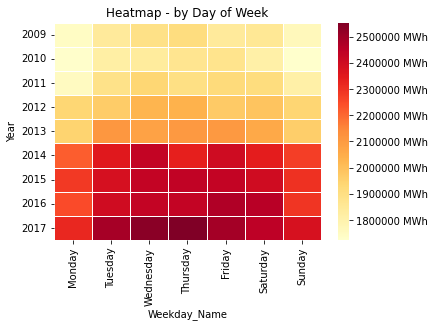

In [14]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Week')

In [15]:
heatmap_data = df.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = df.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2008]
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='energy')

heatmap_data.head(100)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,
2009,509104.586326,478278.283270,464455.337914,453573.493620,450711.848026,450824.252514,473771.809253,508938.085798,533975.983012,547522.750253,...,571926.556584,570087.684884,567528.352142,571566.913284,578941.489826,583555.629770,582251.827370,579853.082898,573137.763112,544537.002112
2010,499298.690556,475181.806353,458719.005553,446818.352483,444024.503570,450292.489812,469325.749612,503617.527426,528999.651770,541128.001653,...,560931.951626,559375.444839,557126.839298,560042.696884,568581.800426,572275.237326,572011.750070,570776.978956,562320.680256,535865.174839
2011,518782.001784,491257.721084,475773.446336,466770.369828,463487.877284,467482.596198,488552.345453,521127.536926,545859.126567,556576.531498,...,582847.168184,580200.586556,579266.733142,583073.006084,588585.365928,592351.290670,591502.060584,590128.372470,580162.960370,552181.714156
2012,547300.932984,519376.996570,506906.149377,494371.477163,491040.306084,496129.153484,517276.825184,552895.025770,579562.900700,593611.794826,...,615007.884437,609718.722853,607667.993609,610976.974426,619007.627339,623951.227698,622570.518570,622902.880584,614122.414156,584931.873553
2013,567188.732026,538186.783539,518989.376088,507454.103711,505474.795112,510337.160353,531098.855798,568123.766042,594761.035470,610126.164998,...,639065.821912,636985.750870,635759.737284,638093.438653,648994.764726,651845.863984,649952.966698,646695.579012,637089.652570,606325.069056
2014,646801.020126,615459.847070,593805.612006,583482.746703,579612.078484,584033.735898,607245.535739,648730.792167,677107.570884,690317.294298,...,727584.682112,723360.345712,723189.845098,727651.053442,733484.645498,740234.649739,738621.443898,736584.755684,723894.125126,689809.466912
2015,658448.258228,623717.168712,602756.470045,590710.635565,586715.306470,592414.372098,615562.232353,658345.949842,687957.237084,704975.127912,...,741270.772567,742352.457084,740262.975712,745533.722828,753587.344726,758427.041470,752604.110595,749921.137739,739095.229326,701987.445926
2016,660515.959598,630184.426712,609502.071326,598160.264711,594950.255626,601386.072256,626719.880709,669849.196539,696675.786039,712222.273412,...,740866.731898,739337.436056,734044.422126,739307.127912,747034.728626,754532.194670,750354.010067,749993.573039,737007.531153,703348.939156
2017,679288.922212,644734.893953,627456.291883,616012.861379,614628.703839,621500.167042,648405.084198,691056.417326,720302.835998,732647.604353,...,757413.223145,756588.127226,753225.930526,757650.714339,770727.970839,775286.331198,772793.998112,772368.317398,760210.844484,723447.726042


Text(0.5, 1.0, 'Heatmap - by Hour of Day')

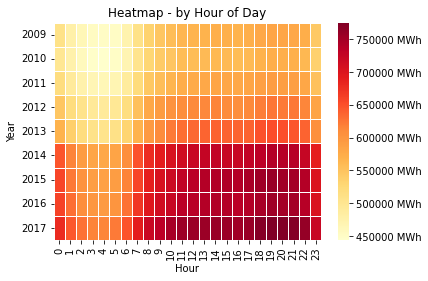

In [16]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Hour of Day')

From heat map we can see that 9am to 9pm are peak of grid

In [17]:
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Month'] = daily_data.index.month_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()

# Reset index
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
#heatmap_data = heatmap_data[heatmap_data['Year'] != 1998]
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='energy')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2008,3.202374e+05,3.251958e+05,8.951133e+05,8.947832e+05,1.024504e+06,1.024059e+06,9.894703e+05,9.400388e+05,8.702707e+05,8.747399e+05,9.542600e+05,1.050956e+06
2009,1.085046e+06,9.278917e+05,9.989234e+05,1.008739e+06,1.106802e+06,1.098339e+06,1.163188e+06,1.106368e+06,9.798200e+05,1.076967e+06,1.086528e+06,1.210544e+06
2010,1.120443e+06,9.301824e+05,1.079074e+06,1.062535e+06,1.103977e+06,1.086876e+06,1.143921e+06,1.018560e+06,9.769352e+05,1.029634e+06,1.029614e+06,1.077794e+06
2011,1.120851e+06,9.440176e+05,9.994929e+05,1.038412e+06,1.114438e+06,1.211023e+06,1.225412e+06,1.130762e+06,1.026542e+06,1.035902e+06,1.073138e+06,1.191928e+06
2012,1.161510e+06,1.014590e+06,1.104986e+06,1.128253e+06,1.171635e+06,1.355996e+06,1.281817e+06,1.140014e+06,1.061724e+06,1.107034e+06,1.160252e+06,1.176146e+06
2013,1.209629e+06,1.052663e+06,1.153764e+06,1.128716e+06,1.280220e+06,1.248513e+06,1.308527e+06,1.169765e+06,1.081420e+06,1.174184e+06,1.230701e+06,1.326002e+06
2014,1.321784e+06,1.106198e+06,1.181296e+06,1.218987e+06,1.418995e+06,1.527077e+06,1.471432e+06,1.429051e+06,1.298123e+06,1.400627e+06,1.389460e+06,1.592957e+06
2015,1.476635e+06,1.218893e+06,1.372468e+06,1.349900e+06,1.441536e+06,1.452905e+06,1.445518e+06,1.300605e+06,1.278236e+06,1.395444e+06,1.424462e+06,1.510130e+06
2016,1.434664e+06,1.226414e+06,1.332581e+06,1.367802e+06,1.436604e+06,1.478288e+06,1.517415e+06,1.448197e+06,1.278454e+06,1.358731e+06,1.375119e+06,1.475617e+06


Text(0.5, 1.0, 'Heatmap - by Day of Month')

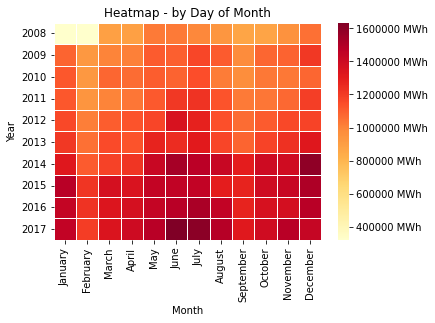

In [18]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Month')

Interestingly, the month that records the highest electricity consumption is june,july in 2017 and december in 2014. This makes sense since it is the hottest period of the year (and hence electricity consumption was probably due to increase aircon use). Contrary to prediction, summer records higher electricity consumption than winter.

# Now let us start with building our models and testing which models is the best.

Models that we are testing:


1.RNN
2.LSTM
3.XGboost

# RNN

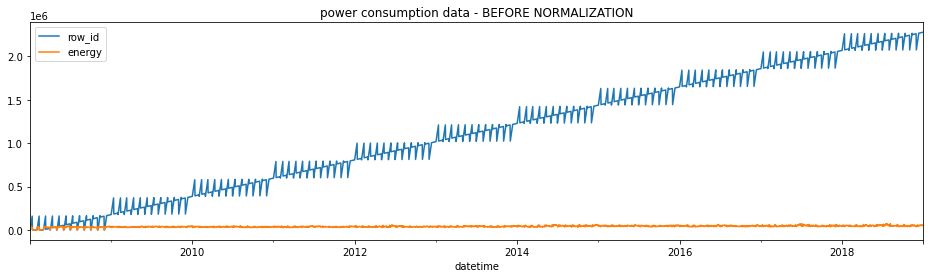

In [19]:
daily_data.plot(figsize=(16,4),legend=True)

plt.title('power consumption data - BEFORE NORMALIZATION')

plt.show()

In [20]:
def normalize_data(train):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['energy']=scaler.fit_transform(df['energy'].values.reshape(-1,1))
    return df

df_norm = normalize_data(train)
df_norm.shape

(94992, 2)

In [21]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)-5):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i+5, 0])

    #1 last 6189 days are going to be used in test
    X_test = X_train[24114:]             
    y_test = y_train[24114:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:24114]           
    y_train = y_train[:24114]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (24114, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [22]:
print(df_norm.shape)

(94992, 2)


In [23]:
seq_len = 70 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (24114, 70, 1)
y_train.shape =  (24114,)
X_test.shape =  (70803, 70, 1)
y_test.shape =  (70803,)


In [24]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [26]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

2023-02-02 14:06:36.370292: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 70, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 70, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 70, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [28]:
rnn_model.compile(optimizer="adam",loss="MSE")
history= rnn_model.fit(X_train, y_train, epochs=17, validation_data=(X_test, y_test), batch_size=100)

2023-02-02 14:06:37.054065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/17
242/242 [==============================] - 69s 275ms/step - loss: 195377536.0000 - val_loss: 3966807296.0000
Epoch 2/17
242/242 [==============================] - 65s 268ms/step - loss: 195118384.0000 - val_loss: 3965600512.0000
Epoch 3/17
242/242 [==============================] - 64s 264ms/step - loss: 194875376.0000 - val_loss: 3964410880.0000
Epoch 4/17
242/242 [==============================] - 63s 261ms/step - loss: 194634192.0000 - val_loss: 3963224320.0000
Epoch 5/17
242/242 [==============================] - 64s 267ms/step - loss: 194394096.0000 - val_loss: 3962045440.0000
Epoch 6/17
242/242 [==============================] - 64s 266ms/step - loss: 194154928.0000 - val_loss: 3960865280.0000
Epoch 7/17
242/242 [==============================] - 68s 280ms/step - loss: 193915664.0000 - val_loss: 3959689728.0000
Epoch 8/17
242/242 [==============================] - 68s 279ms/step - loss: 193677056.0000 - val_loss: 3958512128.0000
Epoch 9/17
242/242 [====================

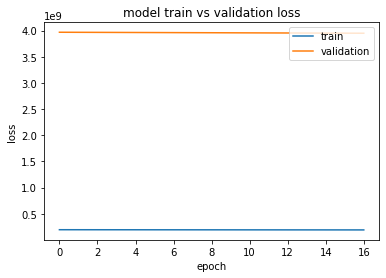

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
from sklearn.metrics import r2_score
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R^2 Score of RNN model = ",rnn_score)

R^2 Score of RNN model =  -8.450380665903527


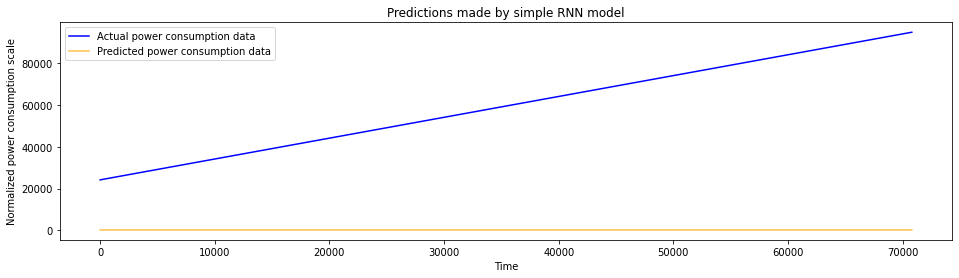

In [31]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# LSTM

In [32]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [33]:
lstm_model.compile(optimizer="adam",loss="MSE")
history_lstm=lstm_model.fit(X_train, y_train, epochs=28, validation_data=(X_test, y_test),batch_size=1000)

Epoch 1/28
25/25 [==============================] - 42s 1s/step - loss: 195600864.0000 - val_loss: 3968230144.0000
Epoch 2/28
25/25 [==============================] - 35s 1s/step - loss: 195481824.0000 - val_loss: 3967763712.0000
Epoch 3/28
25/25 [==============================] - 35s 1s/step - loss: 195410672.0000 - val_loss: 3967528192.0000
Epoch 4/28
25/25 [==============================] - 36s 1s/step - loss: 195371680.0000 - val_loss: 3967368192.0000
Epoch 5/28
25/25 [==============================] - 37s 1s/step - loss: 195340960.0000 - val_loss: 3967224064.0000
Epoch 6/28
25/25 [==============================] - 35s 1s/step - loss: 195312224.0000 - val_loss: 3967086848.0000
Epoch 7/28
25/25 [==============================] - 34s 1s/step - loss: 195284784.0000 - val_loss: 3966952704.0000
Epoch 8/28
25/25 [==============================] - 34s 1s/step - loss: 195258160.0000 - val_loss: 3966821888.0000
Epoch 9/28
25/25 [==============================] - 34s 1s/step - loss: 19523144

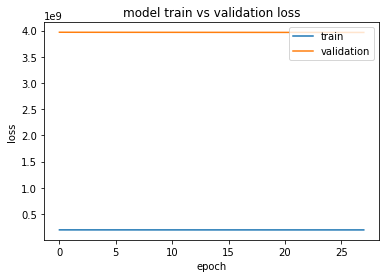

In [34]:
import matplotlib.pyplot as plt
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [35]:
from sklearn.metrics import r2_score
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  -8.489643722629193


# XG Boost

In [36]:
split_date = '31-Dec-2000'
df_train = df.loc[df.index <= split_date].copy() #changed from df_norm
df_test = df.loc[df.index > split_date].copy() #changed from df_norm

In [37]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(94992, 2)
(0, 2)
(94992, 2)


In [38]:
def create_features(daily_data, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [39]:
X_train, y_train = create_features(df_train, label='energy') #PJM_Load_MW output in PJM_Load_hourly.csv
X_test, y_test = create_features(df_test, label='energy')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [40]:
X_train.head(5)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,
2008-01-03 00:00:00,0,3,1,1,2008,3,3,1
2008-01-03 01:00:00,1,3,1,1,2008,3,3,1
2008-01-03 02:00:00,2,3,1,1,2008,3,3,1
2008-01-03 03:00:00,3,3,1,1,2008,3,3,1
2008-01-03 04:00:00,4,3,1,1,2008,3,3,1


In [41]:
y_train.head(5)

datetime
2008-01-03 00:00:00    0.156936
2008-01-03 01:00:00    0.091368
2008-01-03 02:00:00    0.075701
2008-01-03 03:00:00    0.067126
2008-01-03 04:00:00    0.063774
Name: energy, dtype: float64

In [42]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [43]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

output = reg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


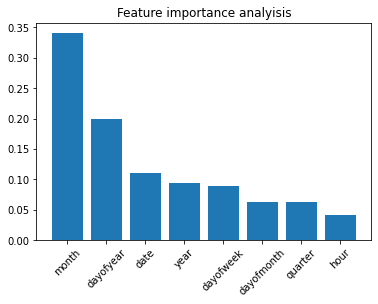

In [44]:
features = ["date", "hour", "dayofweek", "quarter", "month", "year", "dayofyear", "dayofmonth", "weekofyear"]

# Get feature importances from our random forest model
importances = reg.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

In [45]:
from sklearn.metrics import r2_score

In [46]:
lstm_score = r2_score(y_test, output)
print("R^2 Score of XGBoost model = ",lstm_score)

R^2 Score of XGBoost model =  0.9801985861036772


In [47]:
As we can see that XGBooster gives 98% accuracy

SyntaxError: invalid syntax (2331688179.py, line 1)